In [1]:
import pandas as pd 
import numpy as np
from numpy import loadtxt

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt

[[26268.8 3027.0 46 1.691160221]
 [18512.5 3273.0 49 1.817679558]
 [23285.0 1990.0 7 1.104972376]
 [27628.5 3491.0 53 1.93480663]
 [29661.5 4043.5 64 2.256906077]
 [25134.8 3295.5 41 1.827624309]
 [19989.2 2539.5 13 1.409392265]
 [28449.6 3145.0 37 1.751381215]
 [20883.6 3823.5 73 2.12320442]
 [31003.7 2674.5 20 1.493922652]
 [23880.0 2199.5 14 1.221546961]
 [31097.6 2680.0 31 1.490607735]
 [26172.5 2795.0 32 1.549723757]
 [23078.4 3054.5 32 1.693370166]
 [22623.0 2039.0 13 1.138674033]
 [24925.6 1974.0 7 1.100552486]
 [25977.5 3586.0 66 1.987845304]
 [26186.1 2694.5 32 1.495027624]
 [26935.0 2140.0 17 1.191712707]
 [24282.5 3021.5 48 1.679558011]
 [20802.8 3563.5 75 1.980110497]]
MAPE: 0.5066467625431691
RMSE: 20.98124190870177
RMSRE: 0.650726322717071


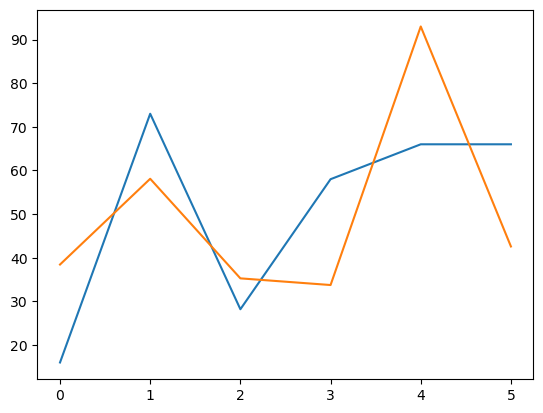

In [2]:
#load data
dataset = pd.read_csv("C:\\Users\\namil\\Downloads\\002data.csv").dropna().to_numpy()
selected_inputs = range(3,7,1)
X = dataset[:,selected_inputs]
Y = dataset[:,8]
print(X)

#split into train and test sets
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#make model
model = XGBRegressor()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

#package error calculations
mape = MAPE(y_test, prediction)
print("MAPE:", mape)
mse = MSE(y_test, prediction)
rmse = mse**0.5
print("RMSE:", rmse)

plt.plot(y_test)
plt.plot(prediction)

#sicong's normalized rmse
arr = ((y_test - prediction)/y_test)**2
rmsre = (np.average(arr))**.5
print("RMSRE:", rmsre)

RMSRE: 1.0834635859721709


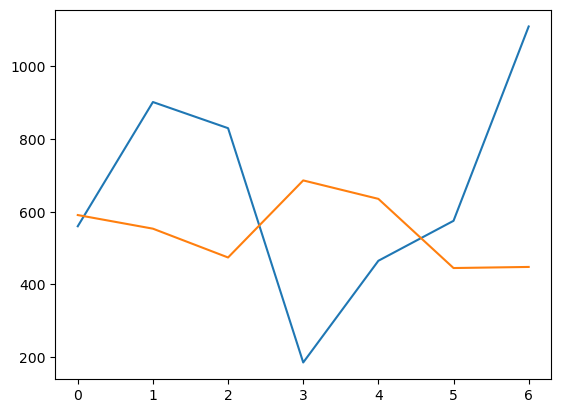

In [5]:
selected_inputs = range(3,7,1)
output = ['calories']
test = pd.read_csv("C:\\Users\\namil\\Documents\\stmi-lab-namila\\allmetrics2")

valid = test[test['dexcom 3hr auc'] != "error"]
X = valid.iloc[:, 9:13].to_numpy()
Y = valid['calories'].to_numpy()

#split into train and test sets
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#make model
model = XGBRegressor()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

plt.plot(y_test)
plt.plot(prediction)

#sicong's normalized rmse
arr = ((y_test - prediction)/y_test)**2
rmsre = (np.average(arr))**.5
print("RMSRE:", rmsre)

RMSRE: 0.6992347493904985


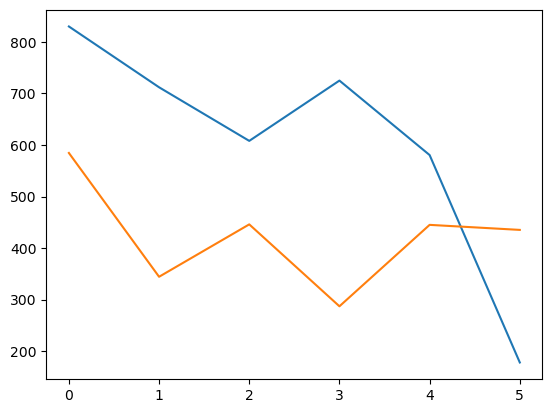

In [7]:
#delete meals w snack nearby
selected_inputs = range(3,7,1)
output = ['calories']
test = pd.read_csv("C:\\Users\\namil\\Documents\\stmi-lab-namila\\allmetrics2")
test = test[test['snack in 3hrs'] == False]

valid = test[test['dexcom 3hr auc'] != "error"]
X = valid.iloc[:, 9:13].to_numpy()
Y = valid['calories'].to_numpy()

#split into train and test sets
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#make model
model = XGBRegressor()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

plt.plot(y_test)
plt.plot(prediction)

#sicong's normalized rmse
arr = ((y_test - prediction)/y_test)**2
rmsre = (np.average(arr))**.5
print("RMSRE:", rmsre)